In [1]:
# Importing Various Modules.
# **************************
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

Using TensorFlow backend.


In [2]:
# Preparing the Data
# **********************
# Making the functions to get the training and validation set from the Images
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR='D:\\flowers\\daisy'
FLOWER_SUNFLOWER_DIR='D:\\flowers\\dandelion'
FLOWER_TULIP_DIR='D:\\flowers\\rose'
FLOWER_DANDI_DIR='D:\\flowers\\sunflower'
FLOWER_ROSE_DIR='D:\\flowers\\tulip'

In [3]:
def assign_label(img,flower_type):
    return flower_type

In [4]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

In [5]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

100%|████████████████████████████████████████| 769/769 [00:13<00:00, 55.84it/s]


769


In [6]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

 99%|█████████████████████████████████████▋| 1048/1055 [00:16<00:00, 56.62it/s]

error: OpenCV(4.0.0) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


 99%|█████████████████████████████████████▋| 1048/1055 [00:29<00:00, 56.62it/s]

In [7]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))


 86%|██████████████████████████████████▌     | 678/784 [00:12<00:01, 66.72it/s]


100%|████████████████████████████████████████| 784/784 [00:14<00:00, 55.24it/s]

2605


In [8]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))


 83%|█████████████████████████████████       | 606/734 [00:12<00:03, 38.33it/s]


100%|████████████████████████████████████████| 734/734 [00:15<00:00, 46.67it/s]

3339


In [9]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))


 56%|██████████████████████▍                 | 552/984 [00:15<00:20, 21.10it/s]


100%|████████████████████████████████████████| 984/984 [00:27<00:00, 35.55it/s]

4323


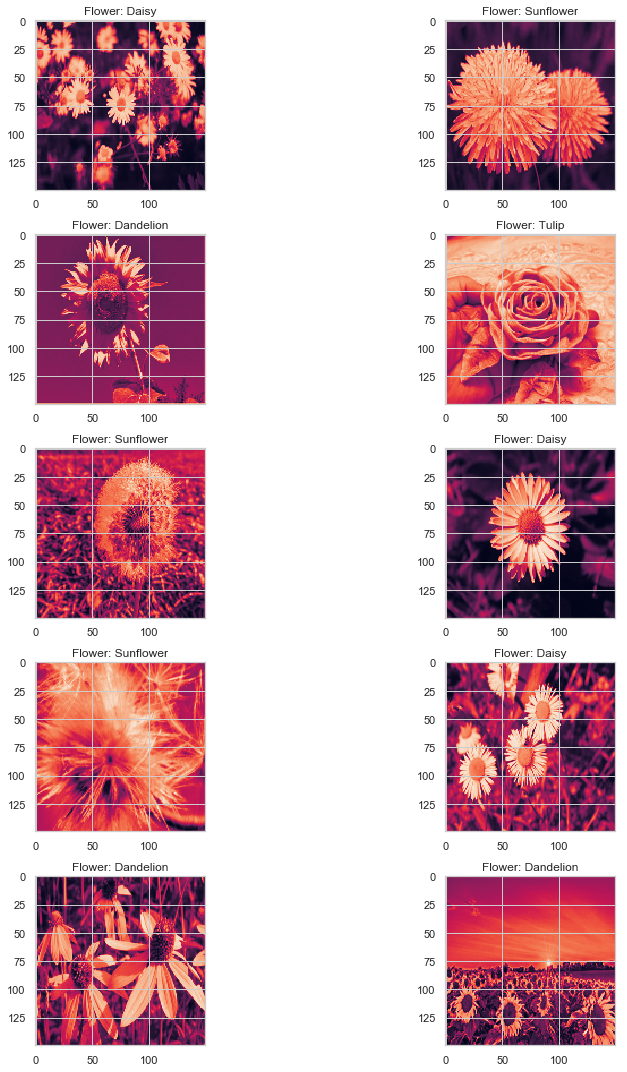

In [10]:
#Visualizing some Random Images
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()

In [11]:
#Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)

In [12]:
X=np.array(X)
X=X/255

In [13]:
#2.4  Splitting into Training and Validation Sets
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)


In [14]:
#2.5 ) Setting the Random Seeds
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)
 



In [15]:
#3 ) Modelling
#3.1 ) Building the ConvNet Model
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,1)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))


Instructions for updating:
Colocations handled automatically by placer.


In [16]:
#3.2 ) Using a LR Annealer
batch_size=128
epochs=50
from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)


In [17]:

#3.3 ) Data Augmentation to prevent Overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)



ValueError: Input to `.fit()` should have rank 4. Got array with shape: (3242, 150, 150)

##### test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('dataset/training_set',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('dataset/test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

In [ ]:
#3.4 ) Compiling the Keras Model & Summary
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()


In [ ]:
#3.5 ) Fitting on the Training set and making predcitons on the Validation set
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

In [ ]:
#4 ) Evaluating the Model Performance
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
#5 ) Visualizing Predictons on the Validation Set
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)


In [ ]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break


In [ ]:
#CORRECTLY CLASSIFIED FLOWER IMAGES
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(np.argmax([y_test[prop_class[count]]]))))
        plt.tight_layout()
        count+=1

In [ ]:
#MISCLASSIFIED IMAGES OF FLOWERS
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(np.argmax([y_test[mis_class[count]]]))))
        plt.tight_layout()
        count+=1


https://www.kaggle.com/rajmehra03/flower-recognition-cnn-keras

In [ ]:
lrf=learn.lr_find()
learn.sched.plot()
learn.precompute = False
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
#learn.sched.plot_lr()

In [ ]:
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()


In [2]:
import cv2
  
image = cv2.imread('C:\\Users\\HP\\Desktop\\PHOTO SANDEEP.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  
cv2.imshow('Original image',image)
cv2.imshow('Gray image', gray)
  
cv2.waitKey(0)
cv2.destroyAllWindows()